In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import ImageGrid
import pathlib
import shutil
import cv2
import os
import json
from PIL import Image
import image_to_numpy  # deal with image rotation issue automatically

from engine import train_one_epoch, evaluate
import utils

import torch
import torchvision
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

import warnings
warnings.filterwarnings('ignore')


In [2]:
class SugarcaneWeedsDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transforms=None):
        super().__init__()
        
        self.img_ids = list(sorted(os.listdir(os.path.join(data_dir, "jpg_images_allweeds"))))
        self.img_dir = pathlib.Path(data_dir) / "jpg_images_allweeds"
        with open(os.path.join(data_dir, "weed_labels.json")) as f:
            self.annot = json.load(f)
        self.transforms = transforms
        
    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        
        img_np = image_to_numpy.load_image_file(self.img_dir/img_id)  # to preserve rotation
        img = Image.fromarray(img_np.astype('uint8'), 'RGB')
        
        box_dict = self.annot[img_id]['regions']
        obj_classes = [x['region_attributes']['label'] for x in box_dict]
        num_classes = len(set(obj_classes))
        
        # get bounding box coordinates for each mask
        num_objs = len(obj_classes)
        boxes = []
        for i in range(num_objs):
            if obj_classes[i] == 'weed':  # Weed class only for now
                bd   = box_dict[i]['shape_attributes']
                xmin = bd['x']
                xmax = bd['x'] + bd['width']
                ymin = bd['y']
                ymax = bd['y'] + bd['height']
                boxes.append([xmin, ymin, xmax, ymax])
                
        # convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        if boxes.dim() <= 1:
            raise Exception("Empty bounding boxes list on image id: ", img_id)
        
        
        # instance labels
        labels = torch.ones((len(boxes),), dtype=torch.int64)
#         labels = torch.tensor(labels)

        # no crowd for now
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        image_id = int(img_id[1:5])
        target['image_id'] = torch.tensor([image_id])
        
#         target['filename'] = img_id
#         target['raw_annot'] = annotations
        
        # resize image and target boxes
        new_size_sm = 1024
        raw_size = img.size
        sm_side_raw = min(img.size)
        resize_t = T.Resize(size=new_size_sm)  # resizes smallest side
        img = resize_t(img)
        new_size = img.size
        scale_wd = new_size[0] / raw_size[0]
        scale_ht = new_size[1] / raw_size[1]
        target['boxes'][:,[0,2]] *= scale_wd
        target['boxes'][:,[1,3]] *= scale_ht
        
        # calculate area
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target["area"] = area
        target["iscrowd"] = iscrowd
        
    
        # Apply other transforms. Note - these may not reshape/rescale/flip the underlying image
        #   because bounding boxes are not changed
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, target
    
    def __len__(self):
        return len(self.img_ids)
    

In [3]:
def get_transform(train):
    
    transforms = [
        
    ]
    
    transforms.append(T.ToTensor())
    if train:
#         transforms.append(T.RandomHorizontalFlip(0.5))
        pass
    return T.Compose(transforms)

In [4]:
# # load a pre-trained model for classification and return
# # only the features
# backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# # FasterRCNN needs to know the number of
# # output channels in a backbone. For mobilenet_v2, it's 1280
# # so we need to add it here
# backbone.out_channels = 1280

# # let's make the RPN generate 5 x 3 anchors per spatial
# # location, with 5 different sizes and 3 different aspect
# # ratios. We have a Tuple[Tuple[int]] because each feature
# # map could potentially have different sizes and
# # aspect ratios
# anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
#                                    aspect_ratios=((0.5, 1.0, 2.0),))

# # let's define what are the feature maps that we will
# # use to perform the region of interest cropping, as well as
# # the size of the crop after rescaling.
# # if your backbone returns a Tensor, featmap_names is expected to
# # be [0]. More generally, the backbone should return an
# # OrderedDict[Tensor], and in featmap_names you can choose which
# # feature maps to use.
# roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
#                                                 output_size=7,
#                                                 sampling_ratio=2)

# # put the pieces together inside a FasterRCNN model
# model = FasterRCNN(backbone,
#                    num_classes=2,
#                    rpn_anchor_generator=anchor_generator,
#                    box_roi_pool=roi_pooler)

In [5]:
# ## Test out forward() method
# data_dir = '/Users/mschoder/weeding_project/box_labeled_data'

# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# dataset = SugarcaneWeedsDataset(data_dir, get_transform(train=True))
# data_loader = torch.utils.data.DataLoader(
#  dataset, batch_size=2, shuffle=True, num_workers=4,
#  collate_fn = utils.collate_fn)

# # For Training
# images,targets = next(iter(data_loader))
# images = list(image for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]
# output = model(images,targets)   # Returns losses and detections

# # For inference
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)           # Returns predictions


In [6]:
def get_model_fastrcnn_base(num_classes):
    
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    num_classes = 2  # 1 class (person) + background
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [7]:
# Get DataLoaders
data_dir = '/home/schoder_m/box_labeled_data'

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device: ", device)

# TODO - our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = SugarcaneWeedsDataset(data_dir, get_transform(train=True))
dataset_test = SugarcaneWeedsDataset(data_dir, get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
num_imgs_test = int(len(dataset) * 0.3)
dataset = torch.utils.data.Subset(dataset, indices[:-num_imgs_test])
dataset_test = torch.utils.data.Subset(dataset_test, indices[num_imgs_test:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)


Device:  cuda


In [8]:
# Get a batch of training data
inputs, targets = next(iter(data_loader))

In [9]:
def plot_batch_labels(inputs, targets):
    
    tensor2img = T.ToPILImage()
    n_images = len(inputs)
#     fig,ax = plt.subplots(1,n_images)
    fig = plt.figure(figsize=(16., 4.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, n_images),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
    
    for ax, img, tgt in zip(grid, inputs, targets):
        img = tensor2img(img)
        ax.imshow(img)
        ax.set_title(str(tgt['image_id'].numpy()) + " " + str(img.size) + "  " + str(tgt['labels'].numpy()))
        for box in tgt['boxes'].numpy():
            rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)

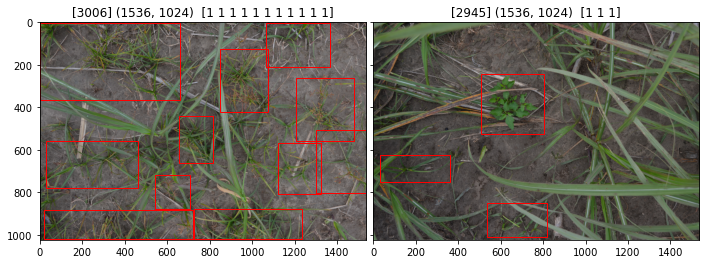

In [10]:
# Plot example batch
plot_batch_labels(inputs, targets)

In [11]:
targets

({'boxes': tensor([[2.3333e+00, 4.3333e+00, 6.6000e+02, 3.6733e+02],
          [8.4933e+02, 1.2333e+02, 1.0757e+03, 4.2233e+02],
          [1.2043e+03, 2.6333e+02, 1.4810e+03, 5.5900e+02],
          [1.3020e+03, 5.0767e+02, 1.5340e+03, 8.0233e+02],
          [1.1203e+03, 5.6700e+02, 1.3263e+03, 8.0800e+02],
          [7.2500e+02, 8.7733e+02, 1.2327e+03, 1.0207e+03],
          [1.8000e+01, 8.8400e+02, 7.2367e+02, 1.0217e+03],
          [5.4433e+02, 7.1700e+02, 7.0667e+02, 8.7833e+02],
          [6.5433e+02, 4.4033e+02, 8.1333e+02, 6.6000e+02],
          [2.8000e+01, 5.5667e+02, 4.6267e+02, 7.7733e+02],
          [1.0653e+03, 1.0000e+00, 1.3667e+03, 2.0833e+02]]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'image_id': tensor([3006]),
  'area': tensor([238733.0000,  67673.6797,  81801.0938,  68362.6719,  49646.0000,
           72765.5547,  97146.7969,  26189.7812,  34927.0000,  95916.4609,
           62476.4570]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [13]:
# TODO - fix - get the model using our helper function
model = get_model_fastrcnn_base(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Epoch: [0]  [  0/100]  eta: 0:07:10  lr: 0.000055  loss: 1.0907 (1.0907)  loss_classifier: 0.7652 (0.7652)  loss_box_reg: 0.1698 (0.1698)  loss_objectness: 0.1417 (0.1417)  loss_rpn_box_reg: 0.0141 (0.0141)  time: 4.3094  data: 1.8043  max mem: 3460
Epoch: [0]  [ 10/100]  eta: 0:01:28  lr: 0.000560  loss: 0.9628 (0.9150)  loss_classifier: 0.4601 (0.4777)  loss_box_reg: 0.1058 (0.1407)  loss_objectness: 0.1417 (0.2269)  loss_rpn_box_reg: 0.0745 (0.0697)  time: 0.9828  data: 0.1727  max mem: 3730
Epoch: [0]  [ 20/100]  eta: 0:01:04  lr: 0.001065  loss: 0.6899 (0.7798)  loss_classifier: 0.3223 (0.3823)  loss_box_reg: 0.1841 (0.1706)  loss_objectness: 0.0795 (0.1592)  loss_rpn_box_reg: 0.0587 (0.0677)  time: 0.6314  data: 0.0100  max mem: 3730
Epoch: [0]  [ 30/100]  eta: 0:00:52  lr: 0.001569  loss: 0.6176 (0.7005)  loss_classifier: 0.2427 (0.3255)  loss_box_reg: 0.1875 (0.1614)  loss_objectness: 0.0796 (0.1431)  loss_rpn_box_reg: 0.0543 (0.0705)  time: 0.6251  data: 0.0109  max mem: 3730


Epoch: [2]  [  0/100]  eta: 0:03:40  lr: 0.005000  loss: 0.2989 (0.2989)  loss_classifier: 0.1065 (0.1065)  loss_box_reg: 0.1119 (0.1119)  loss_objectness: 0.0125 (0.0125)  loss_rpn_box_reg: 0.0679 (0.0679)  time: 2.2097  data: 1.5808  max mem: 3730
Epoch: [2]  [ 10/100]  eta: 0:01:15  lr: 0.005000  loss: 0.4436 (0.4770)  loss_classifier: 0.1951 (0.2269)  loss_box_reg: 0.1626 (0.1706)  loss_objectness: 0.0201 (0.0245)  loss_rpn_box_reg: 0.0604 (0.0550)  time: 0.8375  data: 0.1555  max mem: 3730
Epoch: [2]  [ 20/100]  eta: 0:01:02  lr: 0.005000  loss: 0.4436 (0.4705)  loss_classifier: 0.1966 (0.2209)  loss_box_reg: 0.1506 (0.1672)  loss_objectness: 0.0276 (0.0267)  loss_rpn_box_reg: 0.0588 (0.0557)  time: 0.7077  data: 0.0110  max mem: 3730
Epoch: [2]  [ 30/100]  eta: 0:00:52  lr: 0.005000  loss: 0.4318 (0.4516)  loss_classifier: 0.1972 (0.2111)  loss_box_reg: 0.1348 (0.1542)  loss_objectness: 0.0221 (0.0249)  loss_rpn_box_reg: 0.0642 (0.0614)  time: 0.7089  data: 0.0093  max mem: 3730


Epoch: [4]  [  0/100]  eta: 0:04:22  lr: 0.000500  loss: 0.2315 (0.2315)  loss_classifier: 0.0881 (0.0881)  loss_box_reg: 0.0659 (0.0659)  loss_objectness: 0.0301 (0.0301)  loss_rpn_box_reg: 0.0475 (0.0475)  time: 2.6265  data: 1.7040  max mem: 3730
Epoch: [4]  [ 10/100]  eta: 0:01:18  lr: 0.000500  loss: 0.2282 (0.2796)  loss_classifier: 0.0970 (0.1182)  loss_box_reg: 0.0659 (0.0956)  loss_objectness: 0.0096 (0.0146)  loss_rpn_box_reg: 0.0578 (0.0513)  time: 0.8704  data: 0.1666  max mem: 3730
Epoch: [4]  [ 20/100]  eta: 0:01:02  lr: 0.000500  loss: 0.2282 (0.2801)  loss_classifier: 0.1119 (0.1220)  loss_box_reg: 0.0858 (0.0950)  loss_objectness: 0.0096 (0.0138)  loss_rpn_box_reg: 0.0511 (0.0493)  time: 0.6851  data: 0.0114  max mem: 3730
Epoch: [4]  [ 30/100]  eta: 0:00:52  lr: 0.000500  loss: 0.3030 (0.3005)  loss_classifier: 0.1321 (0.1335)  loss_box_reg: 0.1198 (0.1081)  loss_objectness: 0.0115 (0.0136)  loss_rpn_box_reg: 0.0363 (0.0452)  time: 0.6772  data: 0.0101  max mem: 3730


Epoch: [6]  [  0/100]  eta: 0:03:53  lr: 0.000050  loss: 0.1888 (0.1888)  loss_classifier: 0.0678 (0.0678)  loss_box_reg: 0.0738 (0.0738)  loss_objectness: 0.0025 (0.0025)  loss_rpn_box_reg: 0.0448 (0.0448)  time: 2.3322  data: 1.6344  max mem: 3730
Epoch: [6]  [ 10/100]  eta: 0:01:14  lr: 0.000050  loss: 0.1917 (0.1980)  loss_classifier: 0.0794 (0.0837)  loss_box_reg: 0.0701 (0.0686)  loss_objectness: 0.0061 (0.0071)  loss_rpn_box_reg: 0.0396 (0.0386)  time: 0.8270  data: 0.1642  max mem: 3730
Epoch: [6]  [ 20/100]  eta: 0:00:59  lr: 0.000050  loss: 0.1692 (0.1968)  loss_classifier: 0.0759 (0.0843)  loss_box_reg: 0.0579 (0.0697)  loss_objectness: 0.0057 (0.0060)  loss_rpn_box_reg: 0.0267 (0.0368)  time: 0.6654  data: 0.0137  max mem: 3730
Epoch: [6]  [ 30/100]  eta: 0:00:50  lr: 0.000050  loss: 0.1889 (0.2014)  loss_classifier: 0.0759 (0.0856)  loss_box_reg: 0.0498 (0.0659)  loss_objectness: 0.0060 (0.0079)  loss_rpn_box_reg: 0.0394 (0.0420)  time: 0.6556  data: 0.0101  max mem: 3730


Epoch: [8]  [  0/100]  eta: 0:04:12  lr: 0.000050  loss: 0.1083 (0.1083)  loss_classifier: 0.0431 (0.0431)  loss_box_reg: 0.0468 (0.0468)  loss_objectness: 0.0008 (0.0008)  loss_rpn_box_reg: 0.0175 (0.0175)  time: 2.5254  data: 1.6780  max mem: 3730
Epoch: [8]  [ 10/100]  eta: 0:01:19  lr: 0.000050  loss: 0.2179 (0.2161)  loss_classifier: 0.0843 (0.0897)  loss_box_reg: 0.0509 (0.0721)  loss_objectness: 0.0049 (0.0053)  loss_rpn_box_reg: 0.0518 (0.0490)  time: 0.8812  data: 0.1680  max mem: 3730
Epoch: [8]  [ 20/100]  eta: 0:01:01  lr: 0.000050  loss: 0.2319 (0.2254)  loss_classifier: 0.1094 (0.0962)  loss_box_reg: 0.0802 (0.0764)  loss_objectness: 0.0053 (0.0068)  loss_rpn_box_reg: 0.0500 (0.0461)  time: 0.6836  data: 0.0134  max mem: 3730
Epoch: [8]  [ 30/100]  eta: 0:00:50  lr: 0.000050  loss: 0.2316 (0.2233)  loss_classifier: 0.1057 (0.0959)  loss_box_reg: 0.0762 (0.0744)  loss_objectness: 0.0059 (0.0067)  loss_rpn_box_reg: 0.0431 (0.0463)  time: 0.6407  data: 0.0100  max mem: 3730


In [14]:
# model.eval()

In [15]:
# def visualize_model(model, num_images=6):
#     was_training = model.training
#     model.eval()
#     images_so_far = 0
#     fig = plt.figure()

#     with torch.no_grad():
#         for i, (inputs, labels) in enumerate(dataloaders['val']):
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)

#             for j in range(inputs.size()[0]):
#                 images_so_far += 1
#                 ax = plt.subplot(num_images//2, 2, images_so_far)
#                 ax.axis('off')
#                 ax.set_title('predicted: {}'.format(class_names[preds[j]]))
#                 imshow(inputs.cpu().data[j])

#                 if images_so_far == num_images:
#                     model.train(mode=was_training)
#                     return
#         model.train(mode=was_training)

In [16]:
# Save model
model_path = '/home/schoder_m/sugarcane-weed-classification/fastrcnn_v0.pth'
torch.save(model.state_dict(), '/home/schoder_m/sugarcane-weed-classification/fastrcnn_v0.pth')

# Load Model
# model = torch.load(model_path)

In [17]:
# model.keys()

In [49]:
def plot_batch_labels(inputs, targets):
    
    tensor2img = T.ToPILImage()
    n_images = len(inputs)
#     fig,ax = plt.subplots(1,n_images)
    fig = plt.figure(figsize=(20., 12.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, n_images),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
    
    for ax, img, tgt in zip(grid, inputs, targets):
        print("tgt type: ", type(tgt))
        img = tensor2img(img)
        ax.imshow(img)
#         ax.set_title(str(tgt['image_id'].numpy()) + " " + str(img.size) + "  " + str(tgt['labels'].numpy()))
        for box in tgt['boxes'].cpu().numpy():
            rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)

Prediction: 
 [{'boxes': tensor([[ 148.9748,  480.2358,  376.0073,  665.3732],
        [ 790.2260,  128.0288, 1030.7816,  367.2544],
        [1088.1185,  578.8560, 1527.8594,  995.3741],
        [ 688.0490,  310.4802,  912.6393,  550.5226],
        [1016.6796,  428.3502, 1223.7760,  672.4428],
        [ 872.2662,    2.3849, 1373.1141,  213.5472],
        [  52.6038,   15.7742,  700.4770,  323.1729],
        [  12.1347,   95.7081,  208.7783,  428.2490],
        [ 881.0290,  781.2983, 1130.0032,  997.4468],
        [ 352.8637,  472.1214,  584.2436,  701.2419],
        [   7.8123,  554.4449,  174.2438,  762.4990],
        [ 355.1269,   35.2724,  684.1802,  432.0911],
        [  83.0449,   23.5949,  527.5564,  246.3043],
        [ 397.9056,  145.7197,  653.2106,  390.2908],
        [ 631.9550,  781.1152,  935.9887, 1002.0119],
        [ 737.9509,   79.7408, 1144.9139,  378.8489],
        [ 933.5182,    5.9060, 1298.0599,  143.1643],
        [  11.6110,   11.8181,  196.4801,  131.2298],
   

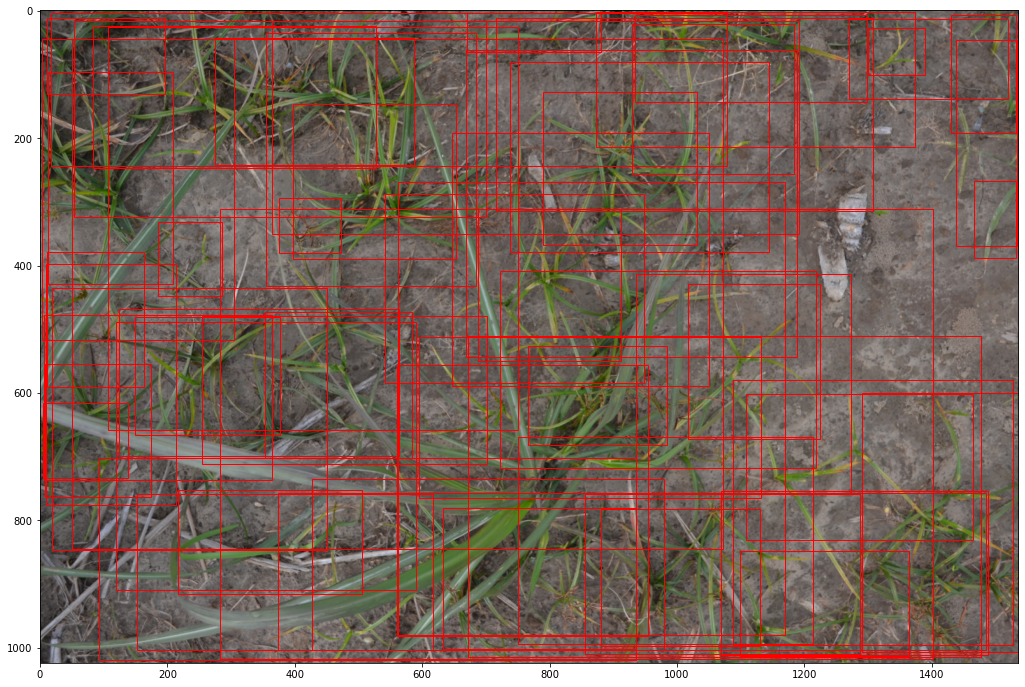

In [51]:
# pick one image from the test set
img, _ = dataset_test[132]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
    
print("Prediction: \n", prediction)

plot_batch_labels([img], prediction)